Source declaration:
- The idea for the experiment as conducted in the code to follow is inspired by discussions among the members of the space weather research group at the university of Bern.
- The construction of the piecewise quadratic spline coupling layer normalizing flow is inspired and taken in part from __[[Diaz Baso et. al.]](https://www.aanda.org/articles/aa/full_html/2022/03/aa42018-21/aa42018-21.html)__.

This code experiments with normalizing flows used to invert Milne-Eddington atmospheres. In this case, a dataset of spectra is generated using synthesis of spectra by means of sampling uniformly from a 9-dimensional parameter space and calculating the spectra based on these parameter sets using the Milne-Eddington model. This dataset is then used to train a normalizing flow, which is tested on a test split of the generated data. In the case at hand, all atmospheric parameters were sampled from an interval of realistic dimensions as acquired from real observational data.

# Import packages, data and define useful functions

In [1]:
# Import all important packages and set parameters
#!pip install emcee
#!pip install corner
#!pip install nflows
import emcee
from __future__ import division
from tqdm import tqdm
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm, amsmath, siunitx}'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy.interpolate import CubicSpline
import torch
import torch.nn as nn
import itertools
import numpy as np
import pandas as pd
from math import pi 
import seaborn as sns
import corner
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn import functional as F

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.coupling import PiecewiseQuadraticCouplingTransform
from nflows.transforms.permutations import ReversePermutation
from nflows import distributions, flows, transforms, utils
from nflows.nn import nets

from sklearn.model_selection import train_test_split

from utils import *

In [2]:
# Fixing seeds for reproducibility
torch.manual_seed(2)
np.random.seed(2)

In [3]:
# Define labels and units for data
stokes_labels = ['$I$ (normalized intensity)', '$Q/I$', '$U/I$', '$V/I$']
labels = ['$|\\bm{B}|$', '$\\theta$', '$\\varphi$', '$v_{los}$', '$\\Delta \\lambda_D = v_{dop}\\lambda/c$', '$\\eta_0$', '$a$', '$S_0$', '$S_1$']
units = ['$[\\mathrm{G}]$', '$[\\si{\\radian}]$', '$[\\si{\\radian}]$', '$[\\si{\kilo\meter\second^{-1}}]$', '$[\\si{\\angstrom}]$', '', '', '', '']
l_units = [label + ' ' + unit for label, unit in zip(labels, units)]

# Generate data

In [4]:
# Import all necessary packages for data generation
import os

# Save current directory
current_directory = os.getcwd()

# Change working path to pyMilne directory and load Milne-Eddington code
os.chdir('/home/dz/pyMilne') # Reference to pyMilne directory
import MilneEddington

# Restore working directory
os.chdir(current_directory)

In [5]:
# Decide to work in float32
dtype = 'float32'

In [6]:
# Define maps, whose data shall be imported
frames = [0]

In [7]:
# Load map data
inverted_map_dict, errors_map_dict, syn_spectra_map_dict = load_inv_maps(frames)
map_inv_dict, hdulist_dict, regions_dict = read_maps(frames)

In [8]:
# Reshape map data
spectra_map0 = map_inv_dict[0].reshape(map_inv_dict[0].shape[0]*map_inv_dict[0].shape[1], map_inv_dict[0].shape[2]*map_inv_dict[0].shape[3])
parameters_map0 = inverted_map_dict[0].reshape(inverted_map_dict[0].shape[0]*inverted_map_dict[0].shape[1], inverted_map_dict[0].shape[2])

In [9]:
# Calculate minimum, maximund and mean values of parameters in this example
min_par = np.min(parameters_map0, axis=0)
max_par = np.max(parameters_map0, axis=0)
mean_par = np.mean(parameters_map0, axis=0)
std_par = np.std(parameters_map0, axis=0)

In [10]:
parameters, spectra, regions = genData2(500000, mean_par, std_par)

line::line: Initialized [6302.493100] ->   3 Zeeman components


pyMilne::dealloc: cleaning-up...


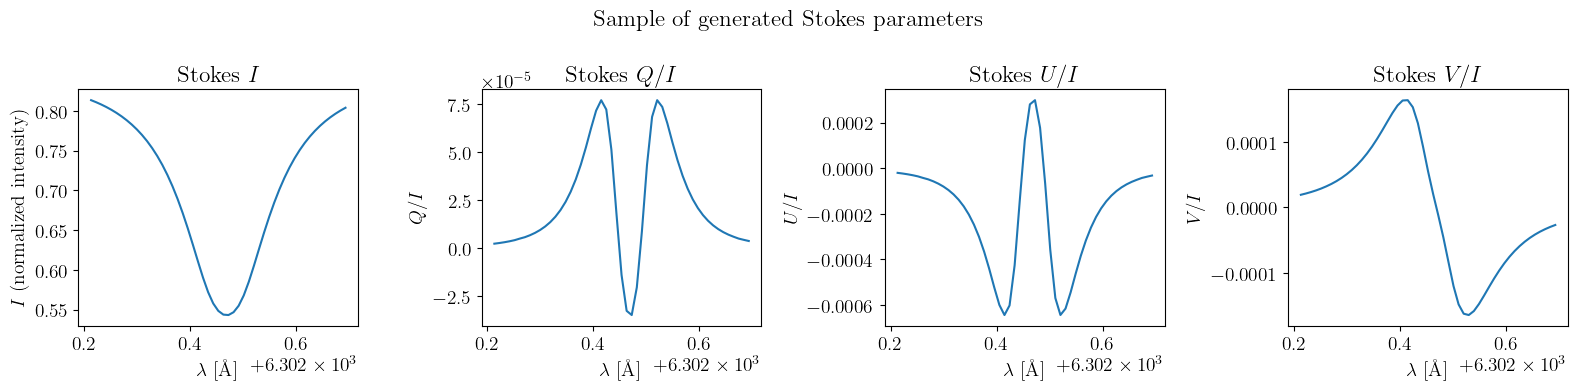

In [14]:
plot_stokes_simple(spectra, regions, 100, stokes_labels, points=51, title='Sample of generated Stokes parameters', savename='nf-milne-eddington-example-3-sample-gen-stokes-nflows-piecewisequadratic.pdf')

In [15]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:',device)
print('Pytorch version:',torch.__version__)
if torch.cuda.is_available() is True:
    print(f'Device type: {torch.cuda.get_device_name(0)}')

Device: cpu
Pytorch version: 2.1.0+cu121


# Create neccessary datasets

In [16]:
# Dictionary to save important information
class dictionary(dict): 
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [17]:
# Instantiate params dictionary
settings = dictionary()

In [18]:
# Reshape parameter and spectra data to suitable form
parameters_r = parameters.reshape(parameters.shape[0], parameters.shape[1])
spectra_r = spectra.reshape(spectra.shape[0], spectra.shape[3]*spectra.shape[4])

In [19]:
# Test for NaN values in data
has_nan = np.isnan(spectra_r).any()
if has_nan==False:
    has_nan = np.isnan(parameters_r).any()

if has_nan:
    print('The data contain NaN values.')
else:
    print('The data do not contain any NaN values.')

The data do not contain any NaN values.


In [20]:
# Make training and testing splits
x_train, x_test, y_train, y_test = train_test_split(parameters_r, spectra_r, test_size=0.2, random_state=42)

In [21]:
# Standardize the input x and context y for training dataset
x_scaler_train = StandardScaler().fit(x_train)
y_scaler_train = StandardScaler().fit(y_train)
x_std_train = x_scaler_train.transform(x_train)
y_std_train = y_scaler_train.transform(y_train)

In [22]:
# Standardize the input x and context y for testing dataset
x_scaler_test = StandardScaler().fit(x_test)
y_scaler_test = StandardScaler().fit(y_test)
x_std_test = x_scaler_test.transform(x_test)
y_std_test = y_scaler_test.transform(y_test)

In [23]:
# Define base distribution z, such that z = f(x) for training dataset
z_train = MultivariateNormal(torch.zeros(x_std_train.shape[1]), torch.eye(x_std_train.shape[1])).rsample(sample_shape=(x_std_train.shape[0],)).detach().numpy()

# Define base distribution z, such that z = f(x) for testing dataset
z_test = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(x_std_test.shape[0],)).detach().numpy()

# Print shapes of training data
print(f'Input x_std_train shape: {x_std_train.shape}')
print(f'Context y_std_train shape: {y_std_train.shape}')
print(f'Output z_train shape: {z_train.shape}')

# Print shapes of testing data
print(f'Input x_std_test shape: {x_std_test.shape}')
print(f'Context y_std_test shape: {y_std_test.shape}')
print(f'Output z_test shape: {z_test.shape}')

Input x_std_train shape: (400000, 9)
Context y_std_train shape: (400000, 204)
Output z_train shape: (400000, 9)
Input x_std_test shape: (100000, 9)
Context y_std_test shape: (100000, 204)
Output z_test shape: (100000, 9)


# Define dataloaders and instantiate normalizing flow

In [24]:
# Convert training data to PyTorch tensors
x_std_train = torch.tensor(x_std_train, dtype=torch.float32) # Make input x to tensor
y_std_train = torch.tensor(y_std_train, dtype=torch.float32) # Make context y to tensor
z_train = torch.tensor(z_train, dtype=torch.float32) # Make target distribution to tensor

# Convert testing data to PyTorch tensors
x_std_test = torch.tensor(x_std_test, dtype=torch.float32) # Make input x to tensor
y_std_test = torch.tensor(y_std_test, dtype=torch.float32) # Make context y to tensor
z_test = torch.tensor(z_test, dtype=torch.float32) # Make target distribution to tensor

In [25]:
# Print sizes of training data
print(f'Size of x_std_train: {x_std_train.size()}')
print(f'Size of y_std_train: {y_std_train.size()}')
print(f'Size of z_train: {z_train.size()}')

# Print sizes of testing data
print(f'Size of x_std_test: {x_std_test.size()}')
print(f'Size of y_std_test: {y_std_test.size()}')
print(f'Size of z_test: {z_test.size()}')

Size of x_std_train: torch.Size([400000, 9])
Size of y_std_train: torch.Size([400000, 204])
Size of z_train: torch.Size([400000, 9])
Size of x_std_test: torch.Size([100000, 9])
Size of y_std_test: torch.Size([100000, 204])
Size of z_test: torch.Size([100000, 9])


In [26]:
# Define dataloaders for training and testing
settings.batch_size = 512
dataset_train = torch.utils.data.TensorDataset(x_std_train, y_std_train) # Input: x, context: y
dataset_test = torch.utils.data.TensorDataset(x_std_test, y_std_test) # Input: x, context: y
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=settings.batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=settings.batch_size, shuffle=True)

In [27]:
# Settings for model
settings.input_size = np.array(x_std_train).shape[1]
settings.context_size = np.array(y_std_train).shape[1]
settings.hidden_size = 32
settings.num_layers = 5

In [28]:
# Define functions for flow definitions
def PiecewiseRationalQuadraticCouplingTransform(iflow, input_size, hidden_size, context_size, num_blocks=1, activation=F.elu, num_bins=8):
    return transforms.PiecewiseRationalQuadraticCouplingTransform(
        mask=utils.create_alternating_binary_mask(input_size, even=(iflow % 2 == 0)),
        transform_net_create_fn=(lambda in_features, out_features: nets.ResidualNet(in_features=in_features, 
        out_features=out_features, hidden_features=hidden_size,context_features=context_size, num_blocks=num_blocks,activation=activation)),
        num_bins=num_bins, tails='linear', tail_bound=5, apply_unconditional_transform=False)

def create_linear_transform(param_dim):
    return transforms.CompositeTransform([
        transforms.RandomPermutation(features=param_dim),
        transforms.LULinear(param_dim, identity_init=True)])

In [29]:
# Instantiate the normalizing flow
base_dist = StandardNormal(shape=[settings.input_size])
flowtransforms = []
for _ in range(settings.num_layers):
    flowtransforms.append(create_linear_transform(param_dim=settings.input_size))
    flowtransforms.append(PiecewiseRationalQuadraticCouplingTransform(_, settings.input_size,
                                                                      settings.hidden_size, context_size=settings.context_size))
    flowtransforms.append(create_linear_transform(param_dim=settings.input_size))
flowtransforms = CompositeTransform(flowtransforms)

flow = Flow(flowtransforms, base_dist)

In [30]:
# Settings for training
settings.learning_rate = 1e-3
settings.scheduling_rate = 0.999
settings.num_epochs = 8

# Define optimizer and scheduler
optimizer = torch.optim.Adam(flow.parameters(), lr=settings.learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, settings.scheduling_rate)

# Train and test the flow

## Train the flow

Train normalizing flow on a train dataset of all spectra and corresponding parameters. Take then a sample from the test split of the spectra and calculate the parameters distributions using the trained normalizing flow and see, if the normalizing flow gives the true value for the parameters in terms of the mean values of the calculated parameter distributions.

In [31]:
# Train the flow
train_losses = []
test_losses = []
epochs = []
for epoch in range(settings.num_epochs):
    epoch_train_losses = []
    epoch_test_losses = []
    for batch_x, batch_y in dataloader_train:
        flow.train()
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=batch_x, context=batch_y).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_losses.append(loss.detach())
    for batch_x, batch_y in dataloader_test:
        flow.eval()
        loss = -flow.log_prob(inputs=batch_x, context=batch_y).mean()
        epoch_test_losses.append(loss.detach())
    epoch_train_loss = sum(epoch_train_losses)/len(dataset_train)
    epoch_test_loss = sum(epoch_test_losses)/len(dataset_test)
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    epochs.append(epoch)
    if (epoch+1) % 1 == 0:
        print('Epoch {}/{} train loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_train_loss))
        print('Epoch {}/{} test loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_test_loss))

Epoch 1/8 train loss: 0.0078
Epoch 1/8 test loss: 0.0023
Epoch 2/8 train loss: -0.0014
Epoch 2/8 test loss: 0.0006
Epoch 3/8 train loss: -0.0043
Epoch 3/8 test loss: -0.0007
Epoch 4/8 train loss: -0.0058
Epoch 4/8 test loss: 0.0003
Epoch 5/8 train loss: -0.0067
Epoch 5/8 test loss: 0.0010
Epoch 6/8 train loss: -0.0071
Epoch 6/8 test loss: 0.0013
Epoch 7/8 train loss: -0.0072
Epoch 7/8 test loss: 0.0012
Epoch 8/8 train loss: -0.0073
Epoch 8/8 test loss: 0.0016


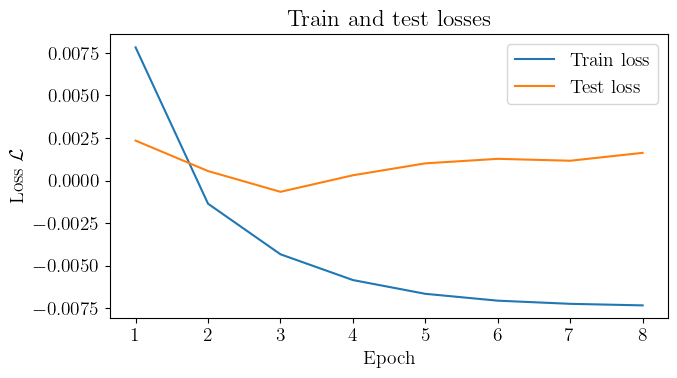

In [32]:
# Print train and test losses
plt.figure(figsize=(7,4))
plt.title('Train and test losses')
plt.xlabel('Epoch')
plt.ylabel('Loss $\\mathcal{L}$')
x_ticks = np.array(epochs) + 1
ticks_param = int(len(epochs)/settings.num_epochs)
selected_ticks = np.array(epochs)[::ticks_param]
plt.xticks(selected_ticks, x_ticks[selected_ticks])
plt.plot(np.array(epochs), train_losses, label='Train loss')
plt.plot(np.array(epochs), test_losses, label='Test loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-3-loss-nflows-piecewisequadratic.pdf')

## Test the flow

The test can be considered successful, if the normalizing flow finds the true value for the parameters, given a certain spectrum; that is, that the true value resides within the range of plus/minus one standard deviation around the mean value of said parameter distribution.

In [33]:
# Take a sample from the testing map
settings.which_dataindex = 1000
settings.exp_samples = 5000
expval = x_test[settings.which_dataindex,:]
expobs = y_test[settings.which_dataindex,:]
z_exp = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(settings.exp_samples,))
y_exp = torch.tensor(np.repeat(expobs[None,:], 1, axis=0))
y_exp_std = torch.tensor(y_scaler_test.transform(y_exp), dtype=torch.float32)

# Sample from the flow using the testobservation y_exp as context
rec_x_std = flow.sample(settings.exp_samples, context=y_exp_std)
rec_x_std = rec_x_std.detach().numpy()
rec_x = x_scaler_test.inverse_transform(rec_x_std[0])

/home/dz/.local/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2192.)
  outputs, _ = torch.triangular_solve(


In [34]:
# Plot actual values of features for tested spectrum
for i in range(len(labels)):
    print(f'{labels[i]}: {expval[i]}')

$|\bm{B}|$: 1119.7002107580802
$\theta$: 1.539836144645447
$\varphi$: 1.7450266888812083
$v_{los}$: -1.8406267807899175
$\Delta \lambda_D = v_{dop}\lambda/c$: 0.03057523173306103
$\eta_0$: 0.01
$a$: 1.3764785602495018
$S_0$: 0.3298685555221748
$S_1$: 0.6007479817000811


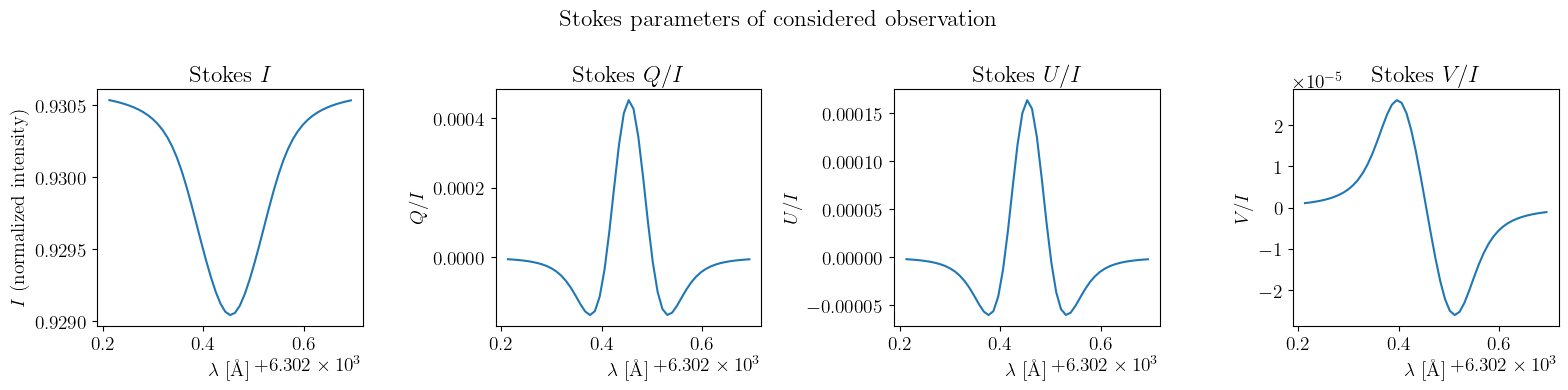

In [36]:
# Plot stokes profiles
plot_stokes_simple(y_test, regions, settings.which_dataindex, stokes_labels, points=51, title='Stokes parameters of considered observation', savename='nf-milne-eddington-example-3-corner-spectrum-nf-nflows-piecewisequadratic.pdf')

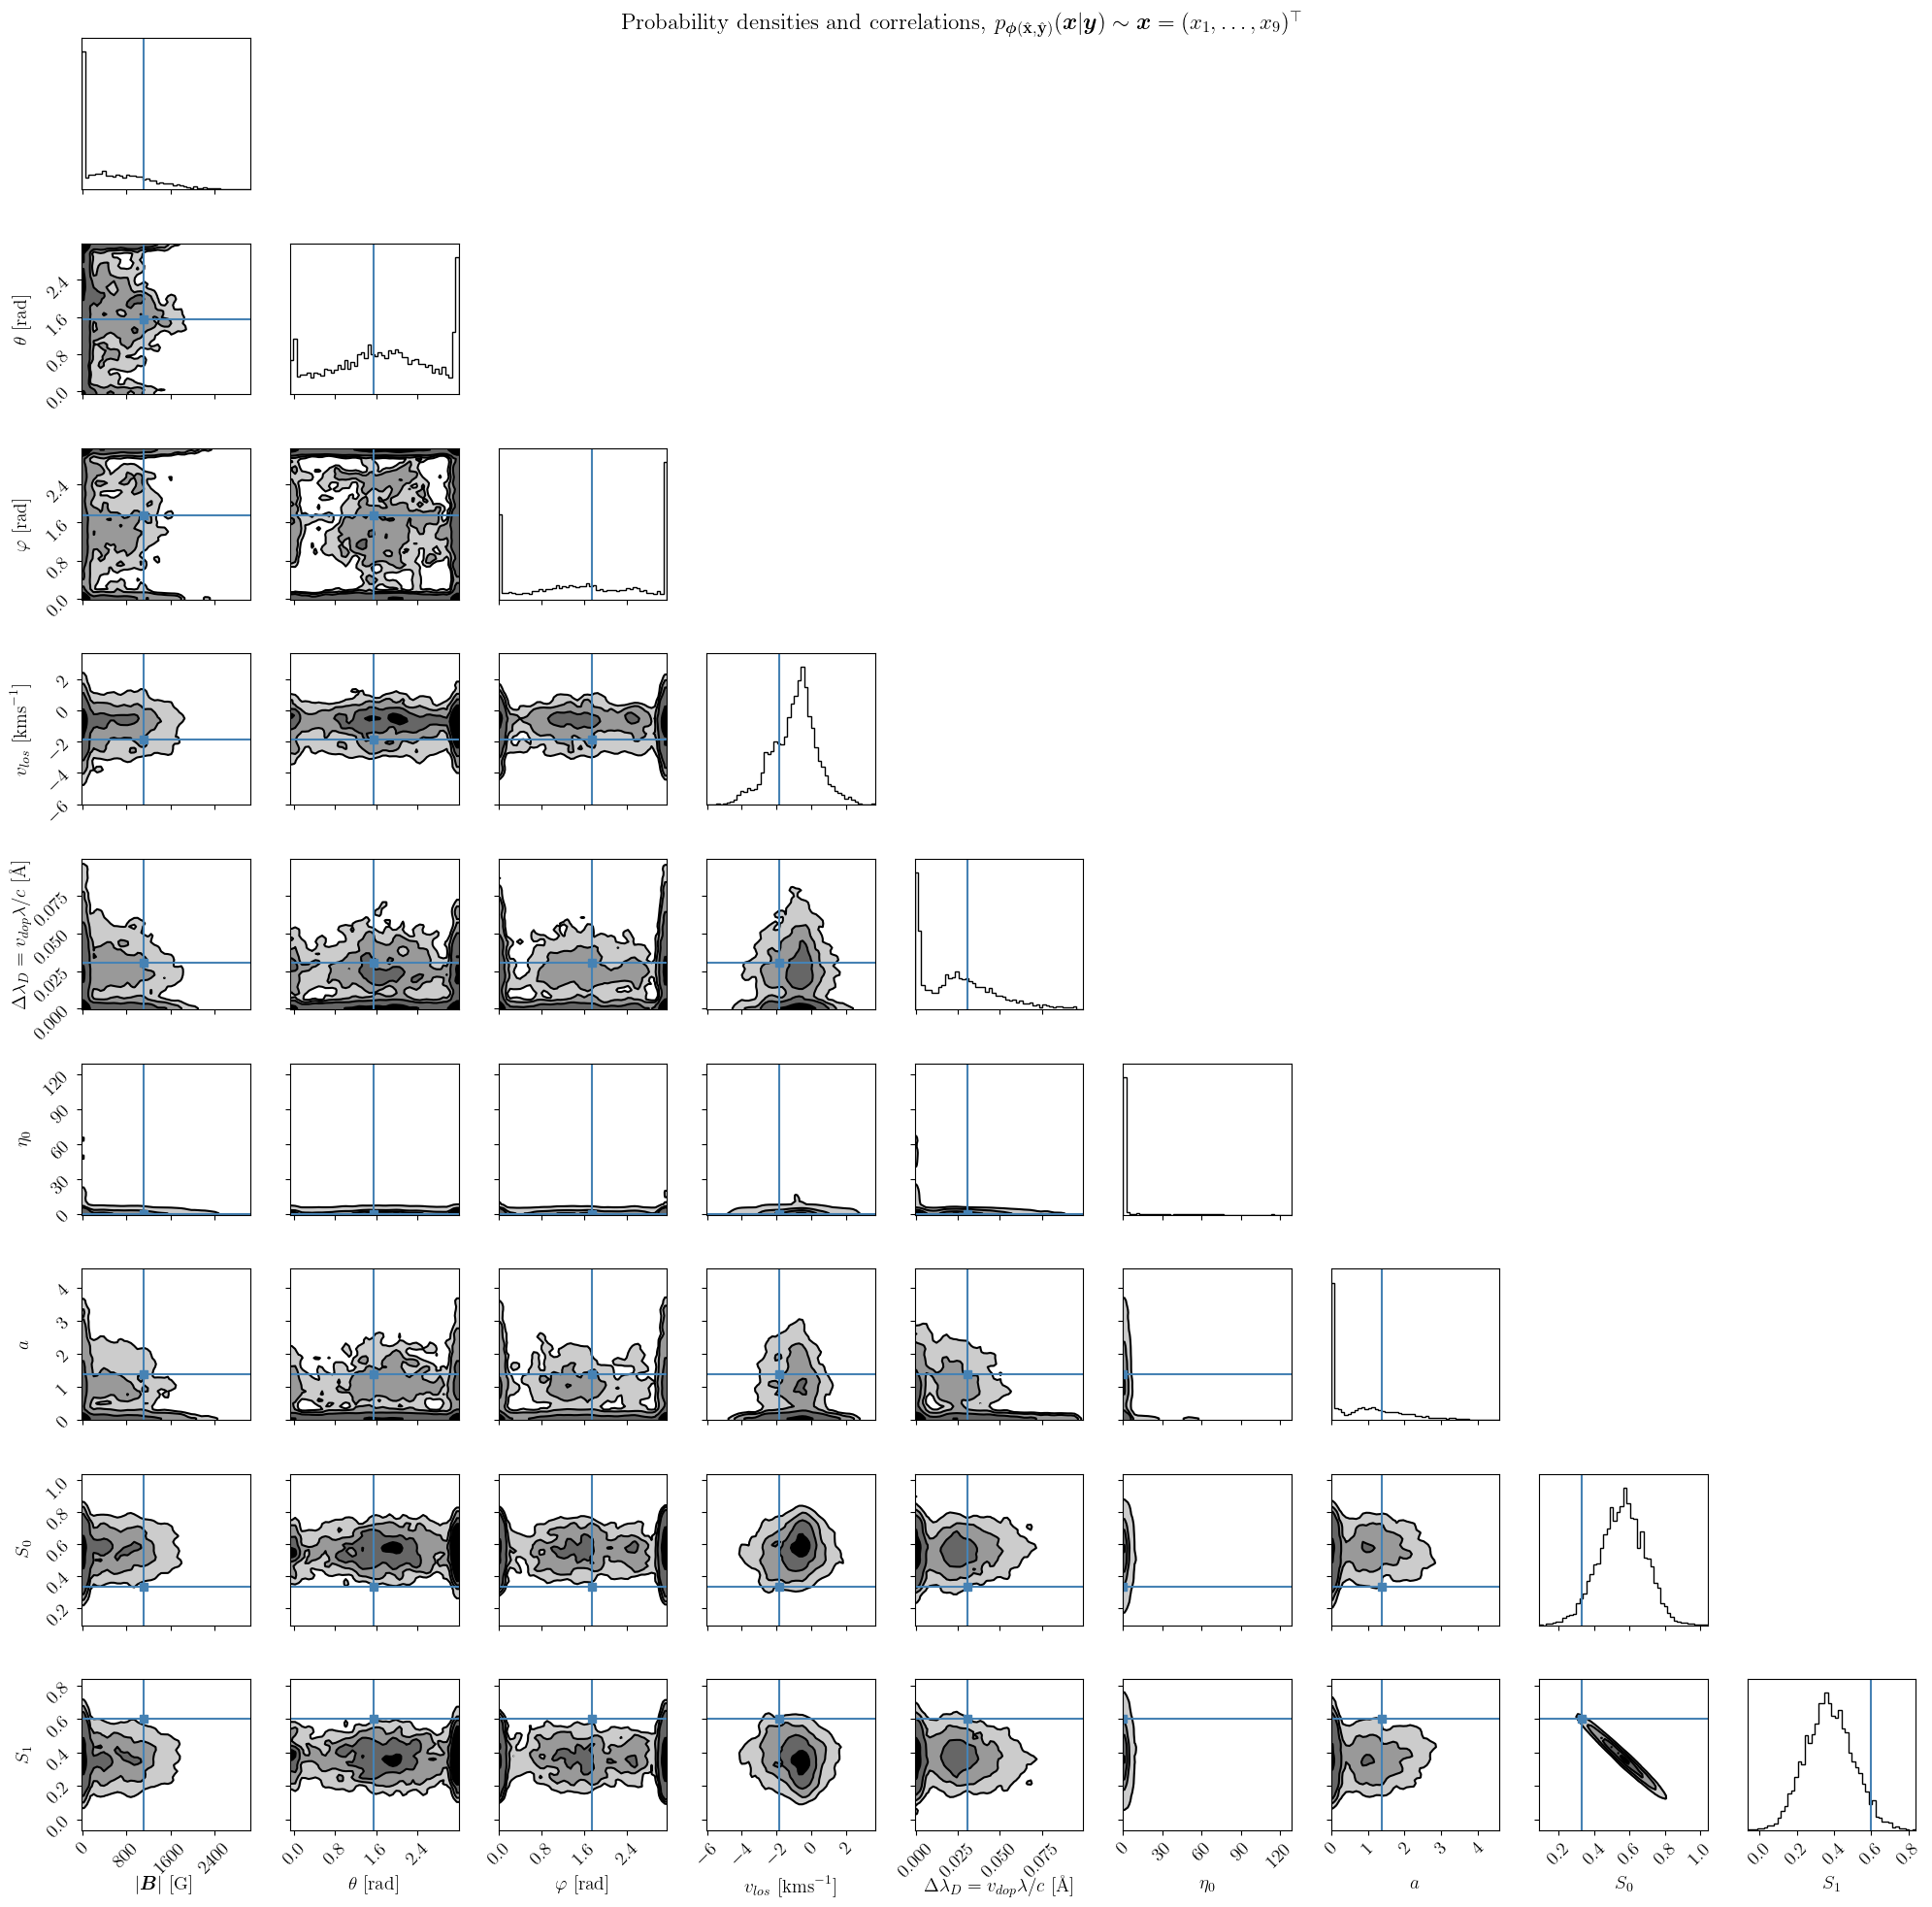

In [37]:
# Produce corner plot
figure = corner.corner(rec_x, labels=l_units, truths=expval, show_titles=False, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
plt.suptitle('Probability densities and correlations, $p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{9})^\\top$')
plt.tight_layout()
plt.savefig('nf-milne-eddington-example-3-corner-nflows-piecewisequadratic.pdf')

In [38]:
# Print settings for training and testing
for key, value in settings.items():
    print(key, ' : ', value)

batch_size  :  512
input_size  :  9
context_size  :  204
hidden_size  :  32
num_layers  :  5
learning_rate  :  0.001
scheduling_rate  :  0.999
num_epochs  :  8
which_dataindex  :  1000
exp_samples  :  5000
